In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
font = {'size'   : 22}
rc('font', **font)
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
rc('text', usetex=True)
plt.rcParams['font.family']='Computer Modern'
import scipy.stats as st
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import statistics
import os
import pandas as pd
from scipy.stats import poisson, lognorm, norm, binom, gamma
from scipy.optimize import minimize
from iminuit import cost, Minuit
from functions import *

In this Notebook we compare our results with the anomaly score cuts + BumpHunt strategy

BumpHunt has trouble working because background model is imperfect and high number of events! Bad scaling unlike Mutual Information!!!!

# Dir definition

In [2]:
WPs_dir='training/'

In [3]:
results_dir='plots/'

In [4]:
y_together = np.load('y_RandD.npy')
labels_together = np.load('labels_RandD.npy')
x_together = np.load('x_RandD.npy')
x_together[:,0]=x_together[:,0]#-x_together[:,1]
nB = np.sum(labels_together==0.0)
print(nB)

999899


In [5]:
np.max(y_together)

9330.74463940652

# Global variables

We decide which $S/B$ we want to consider and which $\lambda$s we want to compare.

In [6]:
lambdas_values = np.load(WPs_dir+'lambda_values.npy')
print(lambdas_values)
soverbs_vals = np.load(WPs_dir+'soverbs.npy')
print(soverbs_vals)
soverbs_labels = np.load(WPs_dir+'soverbs_labels.npy')
print(soverbs_labels)

[0. 1.]
[0.     0.0007 0.0014 0.0035]
['0.0' '0.0025' '0.005' '0.01']


In [7]:
effs_m2 = np.array([1.0,0.1,0.01,0.001])

In [8]:
significances_mutual_info = np.zeros((len(lambdas_values),len(soverbs_labels)))
significances_full_dataset = np.zeros(len(soverbs_labels))
significances_cuts = np.zeros((len(effs_m2),len(soverbs_labels)))
significances_bumphunt = np.zeros((len(effs_m2),len(soverbs_labels)))

In [9]:
def bkg_model(p0,p1,p2,p3):
    exp_values=np.array(list(map(lambda nval: p0*((1-y_norm[nval])**p1)/(y_norm[nval]**(p2+p3*np.log(y_norm[nval]))),range(len(y_norm)))))
    return np.sum(((nbkg-exp_values)/np.sqrt(1.0+1.0*nbkg+0.0*exp_values))**2  )#-np.sum(poisson.logpmf(mu=exp_values,k=nbkg))

In [10]:
def bkg_model_yields(p0,p1,p2,p3):
    exp_values=np.array(list(map(lambda nval: p0*((1-y_norm[nval])**p1)/(y_norm[nval]**(p2+p3*np.log(y_norm[nval]))),range(len(y_norm)))))
    return exp_values

In [11]:
# mass_limits
# same as 2009.02205
y_low = 3100.0
y_high = 3900.0
SR_min = 3300.0
SR_max = 3700.0
y_low_fit = 3100.0
y_high_fit = 3900.0

In [12]:
all_bins = np.arange(y_low_fit/13000,(y_high_fit+50.0)/13000,50.0/13000.0)
print(len(all_bins))

17


In [13]:
all_bins*13000

array([3100., 3150., 3200., 3250., 3300., 3350., 3400., 3450., 3500.,
       3550., 3600., 3650., 3700., 3750., 3800., 3850., 3900.])

In [14]:
bkg_fit = np.zeros((len(effs_m2),len(soverbs_labels),len(all_bins)-1))
bkg_yields = np.zeros((len(effs_m2),len(soverbs_labels),len(all_bins)-1))
sig_yields = np.zeros((len(effs_m2),len(soverbs_labels),len(all_bins)-1))

In [15]:
def bkg_model_yields_m1(p0,p1,p2,p3):
    exp_values=np.array(list(map(lambda nval: p0*((1-y_norm_m1[nval])**p1)/(y_norm_m1[nval]**(p2+p3*np.log(y_norm_m1[nval]))),range(len(y_norm_m1)))))
    return exp_values

In [16]:
def poisson_model(mu,theta):
    return -poisson.logpmf(mu=mu+total_b_m1+theta,k=nM1_selected)+0.5*(theta/total_b_uncertainty_m1)**2

# Iteration per dataset

### expand range of bumphunt fit (2.6-5 TeV for pis fitting) do a single fit following https://journals.aps.org/prd/pdf/10.1103/PhysRevD.99.014038 where large range gives pis and then cut on s(x) on SBs gives efficiency

`nlambda_val` decides which $\lambda$ to use for the Anomaly cuts and the BumpHunt proper. Run twice, one with 0 and with 1 to reproduce the Table.

999899 0
[3300. 3700.]
<ValueView p0=14472.389921993243 p1=11.066177276642499 p2=4.3192016589604165 p3=1.2569502901305485>
1.0948241665553087


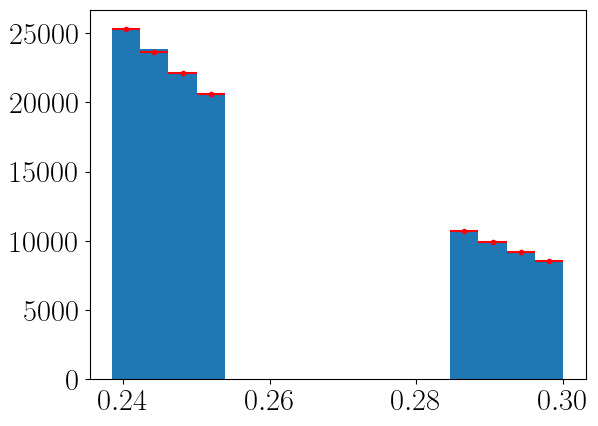

0.0 251417
0.4134643077850342 1.0 1.0 1.0 1.0
121339 121339 1.0


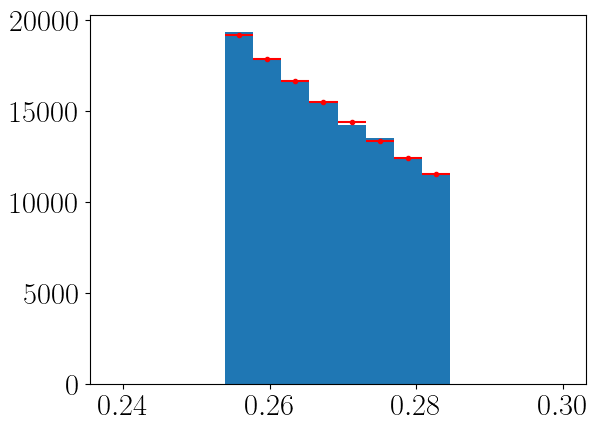

120971.34210324968 142.64966738640342
1.0570673259725025
367.6726633371061
6.772111001995376 7.249850608449352 0.9554792129079512 0.9774861701875639 0.16416426059622535
0.5065177977085114 0.1 0.10333030950661844 0.10333030950660373 0.10657744006461237
12932 121339 0.10657744006461237


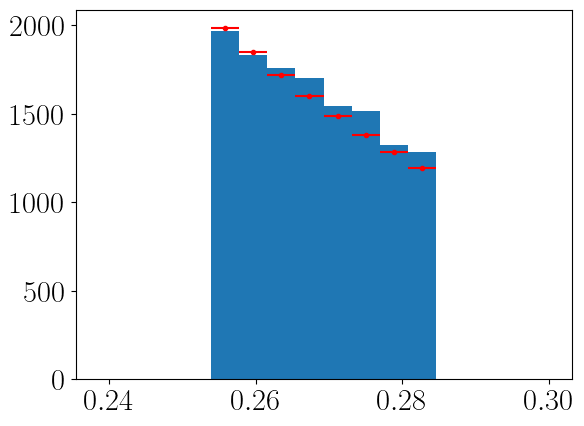

12500.00622095981 14.740034282053237
3.8638688616847503
431.73373148795724
5.652677785820131 12.905422411684901 14.50548925172954 3.808607258792844 6.987586189299844e-05
0.5184618234634399 0.01 0.010001691292921205 0.010001691292916557 0.01025226843801251
1244 121339 0.01025226843801251


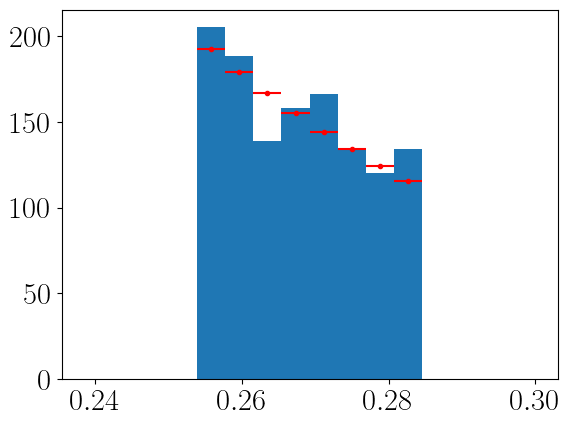

1209.9180190070642 1.4267379362366974
0.9798212580420007
34.0573579343713
4.4820494185963575 4.956822983526281 0.9495471298598464 0.9744470893074936 0.16491729914790043
0.5296773910522461 0.001 0.0010070880548598367 0.0010070880548593922 0.0010301716678067234
125 121339 0.0010301716678067234


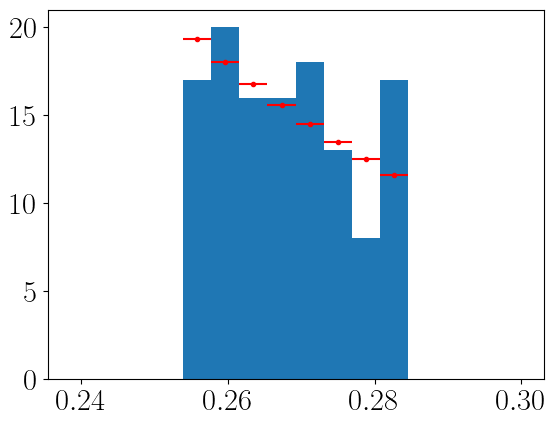

121.82879361254552 0.14366077605457575
0.2873092018799919
3.09075482560633
3.3337946127393967 3.3746748395737005 0.08176045366860762 0.28593784931101307 0.38746286193565804
999899 699
[3300. 3700.]
<ValueView p0=13686.953560965278 p1=11.146447430924377 p2=4.476364430813876 p3=1.3287895884756855>
1.0851097663964113


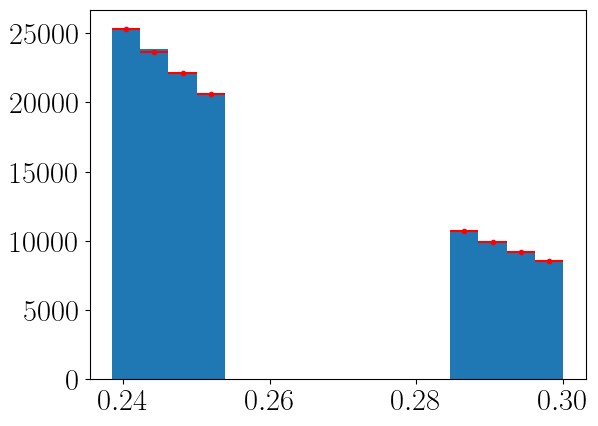

0.0025588942403059565 252062
0.36667609214782715 1.0 1.0 1.0 1.0
121888 121888 1.0


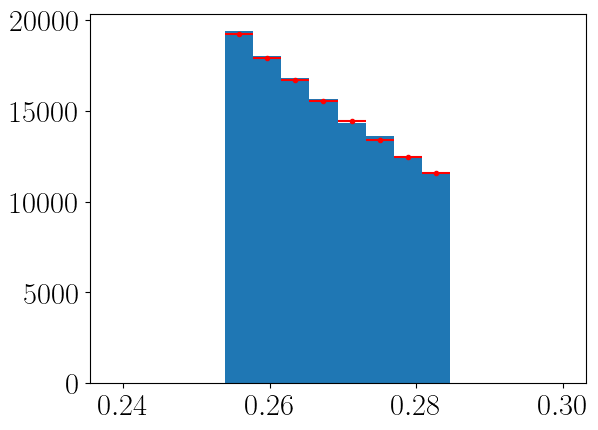

121131.76961580943 143.01239033559548
2.1728267121324985
756.032134423673
6.7743683659624265 8.78933808638681 4.029939440848766 2.007470906600832 0.02234977271329519
0.5052432715892792 0.1 0.097192987847039 0.0971929878470355 0.1005349173011289
12254 121888 0.1005349173011289


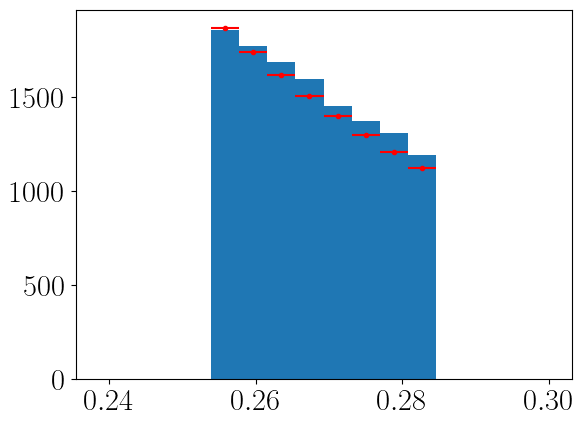

11773.1586121597 13.899801515863528
4.431546844557667
480.62382034634663
5.625751265929199 15.155601557464347 19.059700583070295 4.36574169907821 6.3346061597302494e-06
0.516303688287735 0.01 0.010017361377850297 0.010017361377848111 0.010690141769493306
1303 121888 0.010690141769493306


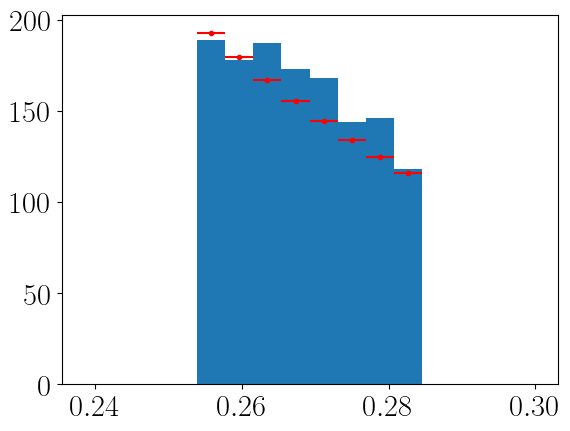

1213.4207105800706 1.4326067955018458
2.571591085097251
89.45970933905893
4.505232303269963 7.727682144235681 6.444899681931435 2.538680697120344 0.005563566264061626
0.5364706218242645 0.001 0.0010063453531429121 0.0010063453531427167 0.0011485954318718823
140 121888 0.0011485954318718823


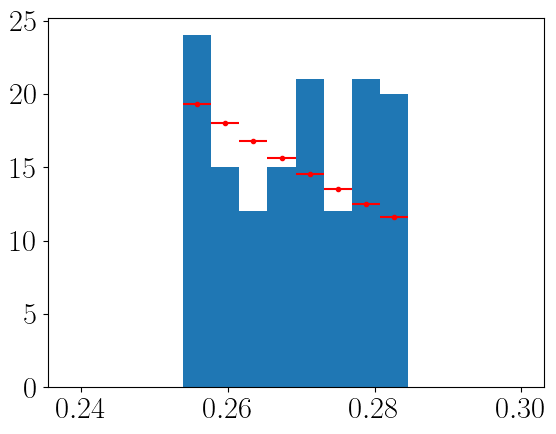

121.90039347084767 0.1439198544560868
1.6393307301386704
18.085811318136205
3.3903603422001036 4.671862342830762 2.5630040012613167 1.600938475164276 0.054695273380716225
999899 1399
[3300. 3700.]
<ValueView p0=13843.773973985672 p1=11.329577672020156 p2=4.6199839185190985 p3=1.4103413537590332>
1.0181953930120715


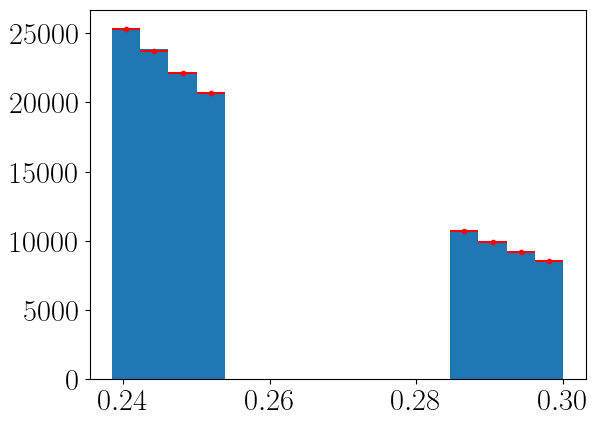

0.005061417671827017 252696
0.4424699544906616 1.0 1.0 1.0 1.0
122410 122410 1.0


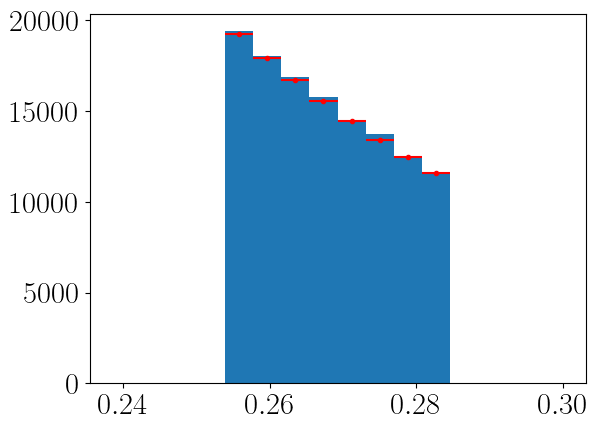

121367.9341956269 144.39036629872155
2.991184245416806
1041.684406981773
6.776505680146282 10.582274044798355 7.611536729304147 2.758901362735563 0.0028998018688635163
0.5041970610618591 0.1 0.10000307016858527 0.10000307016870577 0.10549791683685973
12914 122410 0.10549791683685973


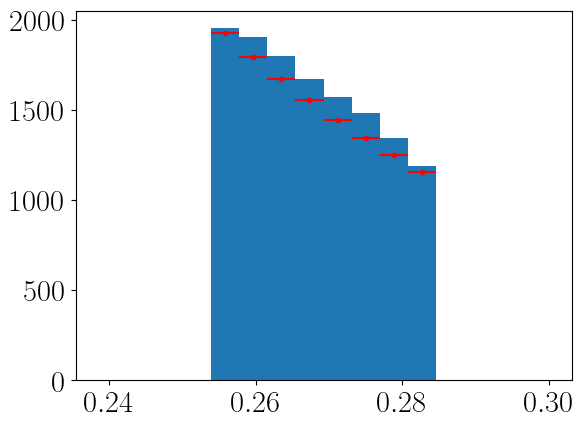

12137.166039581516 14.439479932638779
7.051305913638247
775.9637723154538
5.652013195021661 29.57898500252759 47.85394361501186 6.91765448797581 2.2959412149248237e-12
0.5259597897529602 0.01 0.010001074559036783 0.01000107455904702 0.014149170819377502
1732 122410 0.014149170819377502


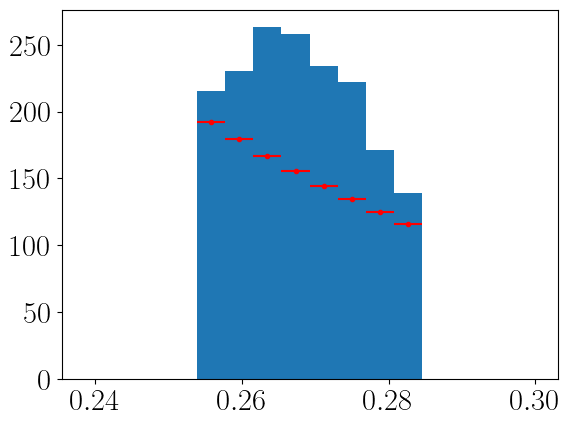

1213.8097589667336 1.444058818960146
14.873525326857587
518.1633355696636
4.647503076565865 102.01592990276353 194.73685365239533 13.954814712220127 0.0
0.5928407311439514 0.001 0.0009901294076099139 0.0009901294076109482 0.0027203659831713093
333 122410 0.0027203659831713093


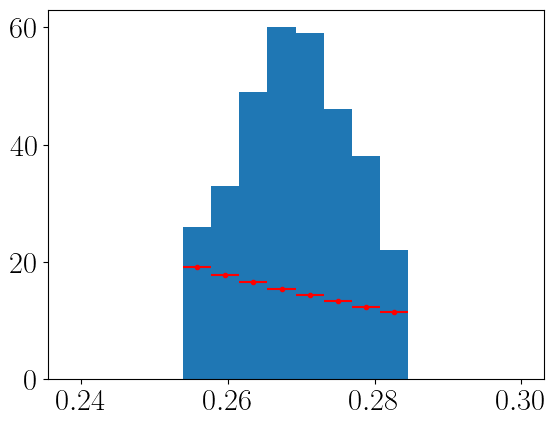

120.16996078795506 0.14296514784793168
19.41489138741643
212.70536668072134
3.8232855693806314 130.36657159808888 253.0865720574165 15.908694857134464 0.0
999899 3499
[3300. 3700.]
<ValueView p0=15673.039343943345 p1=11.858306195013867 p2=4.895144187204622 p3=1.5926168377490226>
0.953777128045725


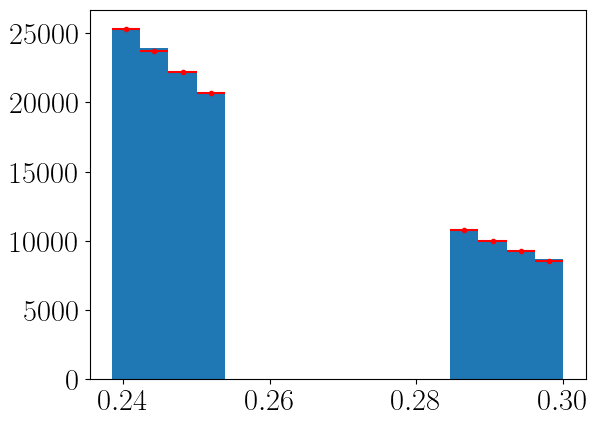

0.01261055343481471 254628
0.4427080750465393 1.0 1.0 1.0 0.999991935418834
123998 123999 0.999991935418834


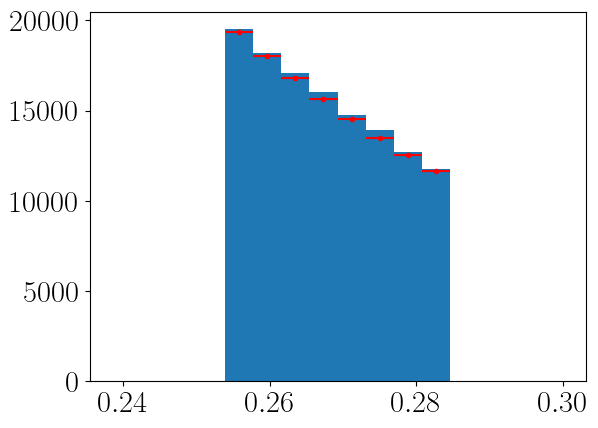

122001.50074810977 140.44547510544706
5.715925574152372
1996.8851780414705
6.782950731275986 20.761579172081344 27.957256881610718 5.287462234532812 6.201247793047315e-08
0.5041813254356384 0.1 0.10000076552678575 0.10000076552679726 0.1130573633658336
14019 123999 0.1130573633658336


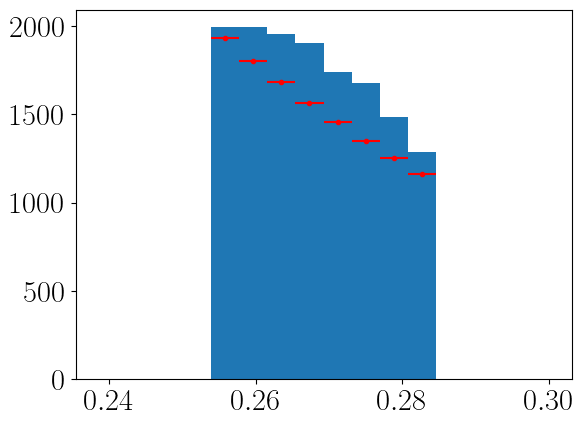

12200.243470227697 14.044655025317837
16.466083626758483
1818.7362131884258
5.693028919026761 132.83181251617899 254.27756719430445 15.946083130170383 0.0
0.5398057103157043 0.01 0.010005435240257387 0.010005435240260586 0.0212421067911838
2634 123999 0.0212421067911838


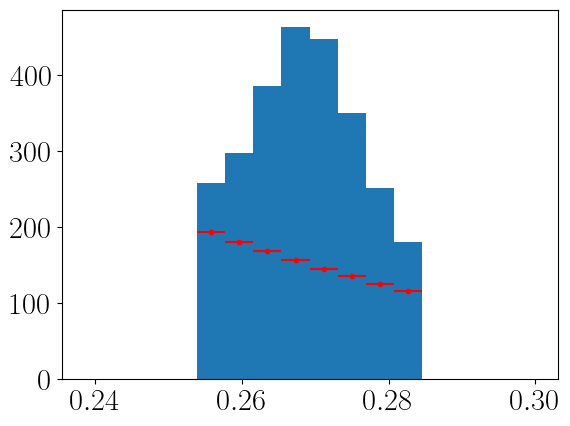

1220.678114949426 1.405218105954732
40.4520471535987
1413.3032153807344
4.85709967871192 616.0179466189596 1222.3216938804953 34.96171754763337 0.0
0.6935868263244629 0.001 0.001002840104417534 0.001002840104417855 0.006121017104976653
759 123999 0.006121017104976653


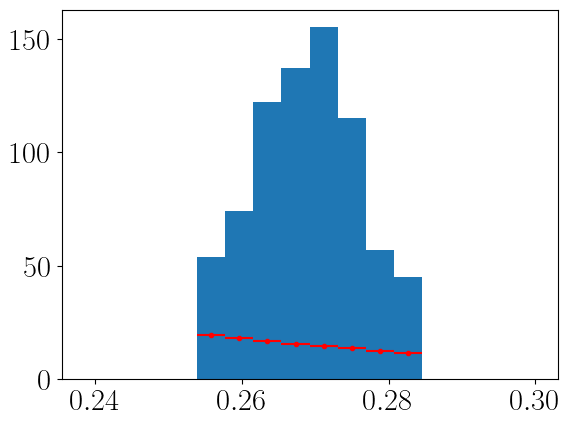

122.3479977493302 0.14084435491971675
57.557732443581656
636.6459909493371
4.2350495679965 752.590201127707 1496.710303119421 38.687340346932885 0.0


In [41]:
for nSoverB in range(0,len(soverbs_vals)):
    y_low = 3100.0
    y_high = 3900.0
    SR_min = 3300.0
    SR_max = 3700.0
    SoverB = soverbs_vals[nSoverB]
    SoverB_label = soverbs_labels[nSoverB]

    nlambda_val_old = 0#np.argmin(Imeasured[nSoverB])
    lambda_val_old = lambdas_values[nlambda_val_old]

    nlambda_val = 1#np.argmin(Imeasured[nSoverB])
    lambda_val = lambdas_values[nlambda_val]

    s_values_full = np.load(WPs_dir+'s_values_'+str(nSoverB)+'.npy')
    s_values_old=s_values_full[nlambda_val_old]
    s_values=s_values_full[nlambda_val]
    
    nS = int(SoverB*nB)#np.sum(labels_together==1.0)#
    print(nB,nS)
    y_together_bis=y_together[:nB+nS]
    labels_together_bis=labels_together[:nB+nS]
    x_together_bis=x_together[:nB+nS]    
    scaler = StandardScaler()
    x_together_bis = scaler.fit_transform(x_together_bis)#labels_together.reshape(-1,1)
    minmax = MinMaxScaler()
    y_together_bis = y_together_bis#minmax.fit_transform(y_together.reshape(-1,1))[:,0]


        
    SR = [all_bins[np.argmin(np.abs(all_bins-SR_min/13000))],all_bins[np.argmin(np.abs(all_bins-SR_max/13000))]]
    SR_fit_min = SR[0]
    SR_fit_max = SR[1]
    print(np.array(SR)*13000)
    indexes_low_sb = y_together_bis<SR_fit_min*13000
    indexes_high_sb = y_together_bis>SR_fit_max*13000
    indexes_selection = [a or b for a,b in zip(indexes_low_sb,indexes_high_sb)]
    nbkg, bins_bkg = np.histogram(y_together_bis[indexes_selection]/13000,bins=all_bins)

    y_norm = 0.5*(bins_bkg[:-1]+bins_bkg[1:])
    bin_widths = 0.5*(bins_bkg[1:]-bins_bkg[:-1])

    lower_bins = all_bins[:-1]<SR_fit_min
    upper_bins = all_bins[1:]>SR_fit_max
    proper_bins = np.array([a or b for a,b in zip(lower_bins,upper_bins)])
    y_norm = y_norm[proper_bins]
    bin_widths=bin_widths[proper_bins]
    nbkg=nbkg[proper_bins]
        

    bkg_model.errordef = Minuit.LEAST_SQUARES

    m = Minuit(bkg_model, p0=np.sum(nbkg)/len(nbkg),p1=0,p2=0,p3=0)

    m.migrad()
    print(m.values)  # x: 2, y: 3, z: 4

    m.hesse()   # run covariance estimator

    mle_vals = m.values
    print(bkg_model(*mle_vals)/(len(y_norm)-4))
        
    error_matrix = np.array(m.covariance)
        
    boostrap_params = np.random.multivariate_normal(mle_vals, error_matrix, size=1000)
    boostrap_yields = np.array(list(map(lambda param: bkg_model_yields(*param), boostrap_params)))
        
    boostrap_yields_mean = np.mean(boostrap_yields,axis=0)
    boostrap_yields_std = np.std(boostrap_yields,axis=0)
        
    plt.hist(y_together_bis[indexes_selection]/13000,bins=bins_bkg);
    plt.errorbar(x=y_norm,y=boostrap_yields_mean,xerr=bin_widths,yerr=boostrap_yields_std,color='red',fmt='.')
    plt.show()    

    x_together_bis=x_together_bis[y_together_bis>=y_low]
    labels_together_bis=labels_together_bis[y_together_bis>=y_low]
    y_together_bis=y_together_bis[y_together_bis>=y_low]

    x_together_bis=x_together_bis[y_together_bis<=y_high]
    labels_together_bis=labels_together_bis[y_together_bis<=y_high]
    y_together_bis=y_together_bis[y_together_bis<=y_high]


    y_nbins=25
    y_bins = np.array([np.quantile(y_together_bis,i*1.0/(y_nbins-1)) for i in range(y_nbins) ])

    print(np.sum(labels_together_bis)/len(labels_together_bis),len(labels_together_bis))

    bins_SR = [np.argmin(np.abs(y_bins-SR_min)),np.argmin(np.abs(y_bins-SR_max))]
    SR = [y_bins[np.argmin(np.abs(y_bins-SR_min))],y_bins[np.argmin(np.abs(y_bins-SR_max))]]
    SR_min = SR[0]
    SR_max = SR[1]
    labels_mixture_together = np.array([1 if a and b else 0 for a,b in zip(y_together_bis>SR[0],y_together_bis<=SR[1])])
    labels_mixture_together_fit = np.array([1 if a and b else 0 for a,b in zip(y_together_bis>SR_fit_min*13000,y_together_bis<=SR_fit_max*13000)])
    bins_SR = [np.argmin(np.abs(y_bins-SR_min)),np.argmin(np.abs(y_bins-SR_max))]

### mutual info comparison
    rel_uncertainty = 0.0099
    s_nbins = round(len(s_values)*rel_uncertainty**2)
    
    s_bins_old = np.array([np.quantile(s_values_old,q=i*1.0/(s_nbins-1)) for i in range(s_nbins) ])
    s_bins = np.array([np.quantile(s_values,i*1.0/(s_nbins-1)) for i in range(s_nbins) ])

    s_bins = np.unique(s_bins)
    s_bins_old = np.unique(s_bins_old)

    s_values_binned, s_bins = np.histogram(s_values,bins=s_bins)
    s_values_binned_old, s_bins_old = np.histogram(s_values_old,bins=s_bins_old)


    while np.sum(1.0/np.sqrt(s_values_binned) > rel_uncertainty) > 0:
        bins_to_merge = []
        nbin = np.where(1.0/np.sqrt(s_values_binned) > rel_uncertainty)[0][0]
        if nbin == 0:
            bins_to_merge=[1]
        elif nbin == len(s_values_binned)-1:
            bins_to_merge=[len(s_values_binned)-1]
        else:
            if s_values_binned[nbin-1] < s_values_binned[nbin+1]:
                bins_to_merge=[nbin]
            else:
                bins_to_merge=[nbin+1]
        s_bins = np.delete(s_bins,bins_to_merge)
        s_values_binned, s_bins = np.histogram(s_values,bins=s_bins)

    while np.sum(1.0/np.sqrt(s_values_binned_old) > rel_uncertainty) > 0:
        bins_to_merge = []
        nbin = np.where(1.0/np.sqrt(s_values_binned_old) > rel_uncertainty)[0][0]
        if nbin == 0:
            bins_to_merge=[1]
        elif nbin == len(s_values_binned_old)-1:
            bins_to_merge=[len(s_values_binned_old)-1]
        else:
            if s_values_binned_old[nbin-1] < s_values_binned_old[nbin+1]:
                bins_to_merge=[nbin]
            else:
                bins_to_merge=[nbin+1]
        s_bins_old = np.delete(s_bins_old,bins_to_merge)
        s_values_binned_old, s_bins_old = np.histogram(s_values_old,bins=s_bins_old)


    indexes_s = [a and b for a, b in zip(s_values>=s_bins[0],s_values<=s_bins[-1])]
    indexes_y = [a and b for a, b in zip(y_together_bis>=y_bins[0],y_together_bis<y_bins[-1])]

    indexes_s_old = [a and b for a, b in zip(s_values_old>=s_bins_old[0],s_values_old<=s_bins_old[-1])]


    indexes = [ a and b for a,b in zip(indexes_s,indexes_y)]
    indexes_old = [ a and b for a,b in zip(indexes_s_old,indexes_y)]

    s_values_filtered = s_values[indexes]
    s_values_filtered_old = s_values_old[indexes_old]
    labels_together_filtered = labels_together_bis[indexes]
    labels_mixture_together_filtered = labels_mixture_together[indexes]
    y_together_bis_filtered = y_together_bis[indexes]

    pD, bb1, bb2 = np.histogram2d(s_values,y_together_bis,bins=[s_bins,y_bins],density=True)
    pD_norm = np.array(list(map(lambda indx: list(map(lambda indy: pD[indx,indy]*(s_bins[indx+1]-s_bins[indx])*(y_bins[indy+1]-y_bins[indy]), range(len(y_bins)-1))), range(len(s_bins)-1))))
    pD_marg_s = np.sum(pD_norm,axis=1)
    pD_marg_s=pD_marg_s/np.sum(pD_marg_s)
    pD_marg_y = np.sum(pD_norm,axis=0)
    pD_marg_y=pD_marg_y/np.sum(pD_marg_y)

    pD_from_marg = np.array(list(map(lambda indx: list(map(lambda indy: pD_marg_s[indx]*pD_marg_y[indy], range(len(y_bins)-1))), range(len(s_bins)-1))))

    I_measured_new = max([mutual_info(pD_norm,pD_marg_s,pD_marg_y),0.0])

    pD_old, bb1, bb2 = np.histogram2d(s_values_old,y_together_bis,bins=[s_bins_old,y_bins],density=True)
    pD_old_norm = np.array(list(map(lambda indx: list(map(lambda indy: pD_old[indx,indy]*(s_bins_old[indx+1]-s_bins_old[indx])*(y_bins[indy+1]-y_bins[indy]), range(len(y_bins)-1))), range(len(s_bins_old)-1))))
        #             print(np.min(pD_norm),np.sum(pD_norm))
    pD_old_marg_s = np.sum(pD_old_norm,axis=1)
    pD_old_marg_s=pD_old_marg_s/np.sum(pD_old_marg_s)
    pD_old_marg_y = np.sum(pD_old_norm,axis=0)
    pD_old_marg_y=pD_old_marg_y/np.sum(pD_old_marg_y)

    pD_old_from_marg = np.array(list(map(lambda indx: list(map(lambda indy: pD_old_marg_s[indx]*pD_old_marg_y[indy], range(len(y_bins)-1))), range(len(s_bins_old)-1))))

    I_measured_old = max([mutual_info(pD_old_norm,pD_old_marg_s,pD_old_marg_y),0.0])
    
    significances_full_dataset[nSoverB] = np.sum(labels_together_bis)/np.sqrt(np.sum(labels_together_bis==0.0)) 
    
    asymptotic_distr = st.gamma(a=0.5*(len(s_bins)-2)*(len(y_bins)-2),scale=1.0/(len(s_values_filtered)))
    
    significances_mutual_info[1,nSoverB]=st.norm.isf(asymptotic_distr.sf(I_measured_new))
    
    asymptotic_distr_old = st.gamma(a=0.5*(len(s_bins_old)-2)*(len(y_bins)-2),scale=1.0/(len(s_values_filtered_old)))
    
    significances_mutual_info[0,nSoverB] = st.norm.isf(asymptotic_distr_old.sf(I_measured_old))
    
    
    weights_m1_m2 = np.zeros(len(labels_mixture_together_fit))
    nM1 = np.sum(labels_mixture_together_fit==1.0)
    nM2 = np.sum(labels_mixture_together_fit==0.0)
    list_of_n = np.array([nM1,nM2])
    min_n = np.min(list_of_n)#[:2])
    list_of_weights=min_n/list_of_n

    weights_m1_m2=np.where(labels_mixture_together_fit==1.0,list_of_weights[0],list_of_weights[1])

    if roc_auc_score(labels_mixture_together_fit,s_values) < 0.5:
        s_values=1-s_values
    fpr_m1_m2, tpr_m1_m2, thr_m1_m2 = roc_curve(labels_mixture_together_fit,s_values,sample_weight=weights_m1_m2)
    for neff in range(len(effs_m2)):
        print("BumpHunt starts here")
        thr_val = thr_m1_m2[np.argmin(np.abs(fpr_m1_m2-effs_m2[neff]))]
        fpr_val = fpr_m1_m2[np.argmin(np.abs(fpr_m1_m2-effs_m2[neff]))]
        indexes_selection =  s_values >= thr_val
        print(thr_val,effs_m2[neff],fpr_val,np.sum(labels_mixture_together_fit[indexes_selection]==0.0)/np.sum(labels_mixture_together_fit==0.0),np.sum(labels_mixture_together_fit[indexes_selection]==1.0)/np.sum(labels_mixture_together_fit==1.0))
        bkg_fit[neff,nSoverB,proper_bins]= fpr_val * boostrap_yields_mean

        nbkg_true_full, all_bins = np.histogram(y_together_bis[indexes_selection][labels_together_bis[indexes_selection]==0.0]/13000,bins=all_bins)
        bkg_yields[neff,nSoverB] = nbkg_true_full
        
        nsig_true_full, all_bins = np.histogram(y_together_bis[indexes_selection][labels_together_bis[indexes_selection]==1.0]/13000,bins=all_bins)
        sig_yields[neff,nSoverB] = nsig_true_full
        
        bins_m1 = all_bins
        nm1, bins_m1 = np.histogram(y_together_bis[indexes_selection][labels_mixture_together_fit[indexes_selection]==1.0]/13000,bins=bins_m1)
        nM1_selected = np.sum(nm1)
        
        nM2_selected = np.sum(labels_mixture_together_fit[indexes_selection]==0.0)
        significances_cuts[neff,nSoverB] = np.max([(nM1_selected-fpr_val*nM1),0.0])/np.sqrt(fpr_val*nM1+nM2_selected)
                                           
        print(nM1_selected,nM1,nM1_selected/nM1)
        y_norm_m1 = 0.5*(bins_m1[:-1]+bins_m1[1:])
        bin_widths_m1 = 0.5*(bins_m1[1:]-bins_m1[:-1])
        
        y_norm_m1 = y_norm_m1[~proper_bins]
        nm1 = nm1[~proper_bins]
        bin_widths_m1 = bin_widths_m1[~proper_bins]
        
        boostrap_yields_m1 = np.array(list(map(lambda param: fpr_val*bkg_model_yields_m1(*param), boostrap_params)))
        boostrap_yields_m1_mean = np.mean(boostrap_yields_m1,axis=0)
        boostrap_yields_m1_std = np.std(boostrap_yields_m1,axis=0)
        
        bkg_fit[neff,nSoverB,~proper_bins]= boostrap_yields_m1_mean
        plt.hist(y_together_bis[indexes_selection][labels_mixture_together_fit[indexes_selection]==1.0]/13000,bins=bins_m1);
        plt.errorbar(x=y_norm_m1,y=boostrap_yields_m1_mean,xerr=bin_widths_m1,yerr=boostrap_yields_m1_std,color='red',fmt='.')
        plt.show()
        
        total_b_m1 = np.sum(boostrap_yields_m1_mean)
        total_b_uncertainty_m1 = np.sqrt(np.sum(boostrap_yields_m1_std**2))
        print(total_b_m1,total_b_uncertainty_m1)      
        print((nM1_selected-total_b_m1)/np.sqrt(total_b_m1))
        
        poisson_model.errordef = Minuit.LIKELIHOOD

        m = Minuit(poisson_model, mu=0,theta=0)

        m.fixed['mu'] = False
        m.migrad()

        m.hesse()   # run covariance estimator
        if m.values[0]>=0.0:
            print(m.values[0])
            val1 = poisson_model(*m.values)
            m = Minuit(poisson_model, mu=0,theta=0)
    
            m.fixed['mu'] = True
            m.migrad()
    
            m.hesse()   # run covariance estimator
            val2 = poisson_model(*m.values)
            print(val1,val2,2*(val2-val1),np.sqrt(2*(val2-val1)),1.0-st.norm.cdf(np.sqrt(2*(val2-val1))))
            
            significances_bumphunt[neff,nSoverB] = np.sqrt(2*(val2-val1))

        else:
            significances_bumphunt[neff,nSoverB] = 0.0




In [ ]:
significances_bumphunt

In [ ]:
significances_cuts

In [ ]:
significances_full_dataset

In [ ]:
significances_mutual_info

# Plot generator

In [43]:
mycolors = [(1., 0.4, 0.0), (0.655728, 0.8, 0.),
   (0., 0.742291, 0.873126), (1., 0.656408, 0.), 
   (0.893126, 0.4, 0.767184), 
   (0.295048, 0.8, 0.286932), 
   (0.238758, 0.610466, 1.), (1., 0.325204, 0.406504),
    (0., 0.786874, 0.739379), (1., 0.520437, 0.), 
   (0.7529330319872088, 0.4176501130047967, 1.), 
   (0.5572809000084149, 0.8, 0), 
   (1., 0.06811595600706821, 0.0851449450088353), (0, 0.7226017980018511, 0.9321946059944466), 
   (1., 0.7154761789941944, 0)];

Plot the output distributions

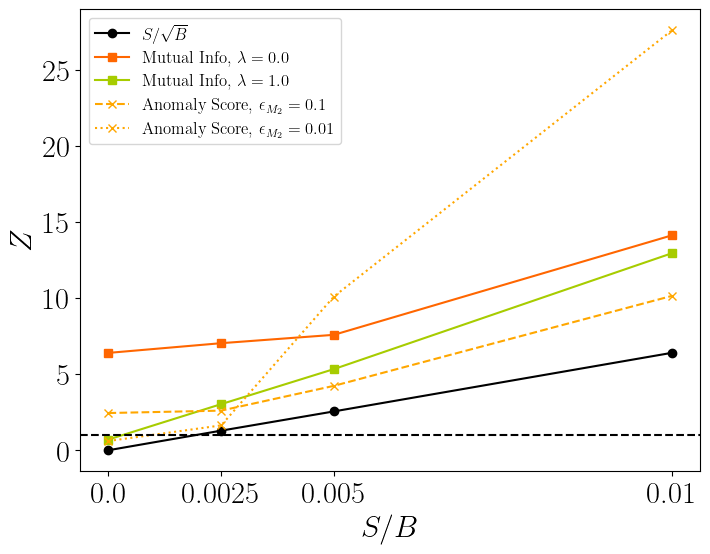

In [44]:
plt.figure(figsize=((2*4,2*3)))
plt.plot(soverbs_vals,significances_full_dataset,color='black', marker='o',label=r'$S/\sqrt{B}$')
plt.plot(soverbs_vals,significances_mutual_info[0],color=mycolors[0], marker='s',label=r'Mutual Info, $\lambda = 0.0$')
plt.plot(soverbs_vals,significances_mutual_info[1],color=mycolors[1], marker='s',label=r'Mutual Info, $\lambda = 1.0$')

# plt.plot(soverbs_vals,significances_cuts[0],color=mycolors[3], marker='x',linestyle='solid',label=r'Anomaly Score, $\epsilon_{M_{2}} = 1.0$')
plt.plot(soverbs_vals,significances_cuts[1],color=mycolors[3], marker='x',linestyle='dashed',label=r'Anomaly Score, $\epsilon_{M_{2}} = 0.1$')
plt.plot(soverbs_vals,significances_cuts[2],color=mycolors[3], marker='x',linestyle='dotted',label=r'Anomaly Score, $\epsilon_{M_{2}} = 0.01$')
# plt.plot(soverbs_vals,significances_cuts[3],color=mycolors[3], marker='x',linestyle='dashdot',label=r'Anomaly Score, $\epsilon_{M_{2}} = 0.001$')

# plt.plot(soverbs_vals,significances_bumphunt[0],color=mycolors[2], marker='x',linestyle='solid',label=r'BumpHunt, $\epsilon_{M_{2}} = 1.0$')
# plt.plot(soverbs_vals,significances_bumphunt[1],color=mycolors[2], marker='x',linestyle='dashed',label=r'BumpHunt, $\epsilon_{M_{2}} = 0.1$')
# plt.plot(soverbs_vals,significances_bumphunt[2],color=mycolors[2], marker='x',linestyle='dotted',label=r'BumpHunt, $\epsilon_{M_{2}} = 0.01$')
# plt.plot(soverbs_vals,significances_bumphunt[3],color=mycolors[2], marker='x',linestyle='dashdot',label=r'BumpHunt, $\epsilon_{M_{2}} = 0.001$')

plt.axhline(1.0,linestyle='dashed',color='black')
# plt.axhline(1.0,label='$Z=1$',linestyle='dashed',color='black')
# plt.axhline(1.0,label='$Z=1$',linestyle='dashed',color='black')

# plt.yticks(np.arange(0,16,2.0))
plt.xticks(soverbs_vals,soverbs_labels)
plt.legend(loc='upper left',fontsize=12)
plt.xlabel(r'$S/B$')
plt.ylabel(r'$Z$')
plt.savefig(results_dir+'comparison_with_bumphunt.pdf')
plt.savefig(results_dir+'comparison_with_bumphunt.png')

In [26]:
significances_bumphunt[2]

array([ 3.1066909 ,  0.77207556, 12.98501626, 32.78183338])

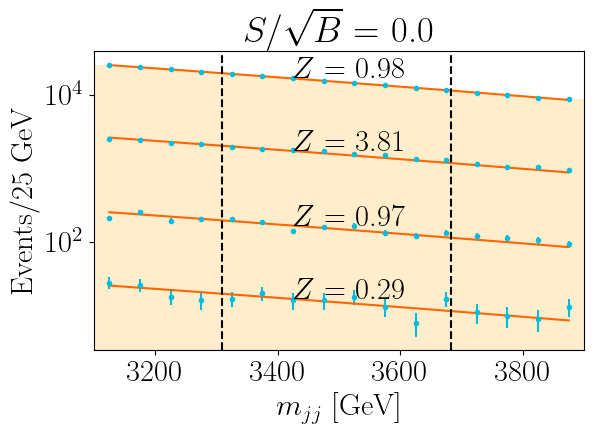

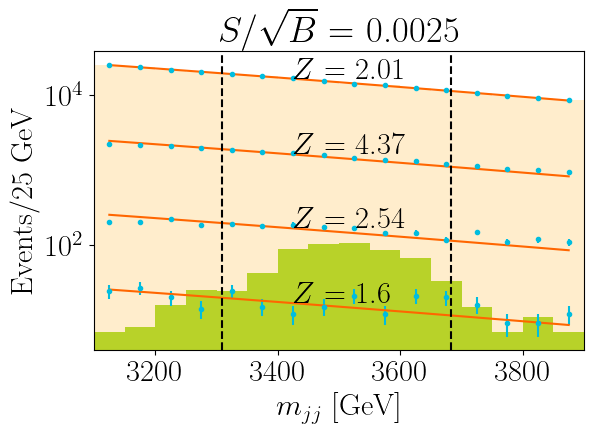

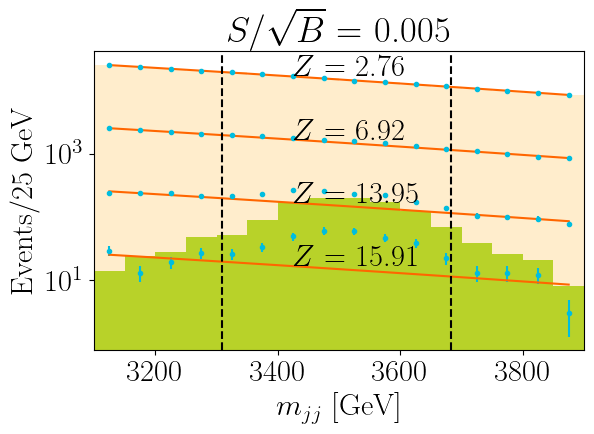

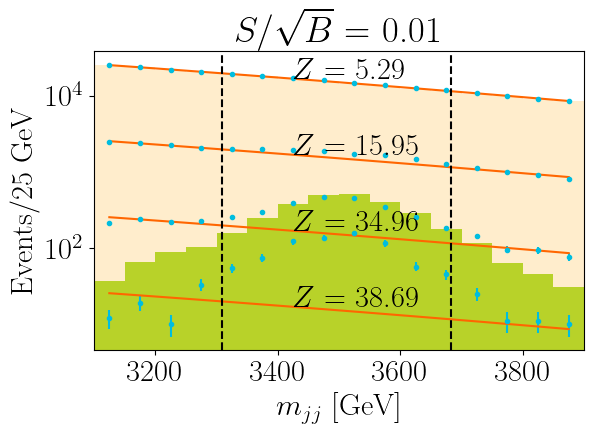

In [45]:
for nSoverB in range(0,len(soverbs_vals)):
    plt.hist(0.5*(all_bins[:-1]+all_bins[1:])*13000,weights=bkg_yields[0,nSoverB],bins=all_bins*13000,color=mycolors[3],alpha=0.2)
    plt.hist(0.5*(all_bins[:-1]+all_bins[1:])*13000,weights=sig_yields[0,nSoverB],bins=all_bins*13000,color=mycolors[1],alpha=0.8)
    # plt.hist(0.5*(all_bins[:-1]+all_bins[1:])*13000,weights=bkg_yields[0,0]+sig_yields[0,0],bins=all_bins*13000,histtype='step',color=mycolors[1])
    for neff in range(len(effs_m2)):
        plt.errorbar(x=0.5*(all_bins[:-1]+all_bins[1:])*13000,y=bkg_yields[neff,nSoverB]+sig_yields[neff,nSoverB],yerr=np.sqrt(bkg_yields[neff,nSoverB]+sig_yields[neff,nSoverB]),fmt='.',color=mycolors[2])
        plt.plot(0.5*(all_bins[:-1]+all_bins[1:])*13000,bkg_fit[neff,nSoverB],color=mycolors[0])
        plt.text(0.5*(all_bins[int(len(all_bins)*0.4)]+all_bins[int(len(all_bins)*0.4)+1])*13000,bkg_fit[neff,nSoverB,int(len(all_bins)*0.4)],r'$Z$ = '+str(round(significances_bumphunt[neff,nSoverB],2)))

    plt.axvline(SR_min,color='black',linestyle='dashed')
    plt.axvline(SR_max,color='black',linestyle='dashed')
    plt.xlim(y_low,y_high)
    plt.yscale('log')
    plt.xlabel(r'$m_{jj}$ [GeV]')
    plt.ylabel('Events/25 GeV')
    plt.title(r'$S/\sqrt{B}$ = '+soverbs_labels[nSoverB])
    plt.tight_layout()
    plt.savefig(results_dir+'bumphunt_'+str(nSoverB)+'.pdf')
    plt.savefig(results_dir+'bumphunt_'+str(nSoverB)+'.png')
    plt.show()